In [11]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score
from tqdm import tqdm

In [2]:
dataset = load_dataset("hendzh/PromptShield")

In [12]:
MODEL_NAME = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
MAX_LEN = 128  # faster, enough for most prompts

def tokenize(example):
    return tokenizer(example["prompt"], padding="max_length", truncation=True, max_length=MAX_LEN)

# Tokenize and keep label
tokenized = dataset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/18909 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [29]:
class PromptDataset(Dataset):
    def __init__(self, dataset_split):
        self.dataset = dataset_split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "labels": item["label"]
        }


In [30]:
train_loader = DataLoader(PromptDataset(tokenized["train"]), batch_size=32, shuffle=True)
val_loader = DataLoader(PromptDataset(tokenized["validation"]), batch_size=32)
test_loader = DataLoader(PromptDataset(tokenized["test"]), batch_size=32)

In [31]:
class TinyBERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze base
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2)
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # skip gradients for frozen BERT
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyBERTClassifier().to(device)

# Handle class imbalance
labels = [ex["label"] for ex in dataset["train"]]
class_counts = torch.bincount(torch.tensor(labels))
weights = 1.0 / class_counts.float()
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-4)


In [33]:
EPOCHS = 8
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|██████████| 591/591 [00:11<00:00, 50.13it/s]


Epoch 1: Avg Loss = 0.3897


Epoch 2: 100%|██████████| 591/591 [00:11<00:00, 53.36it/s]


Epoch 2: Avg Loss = 0.3056


Epoch 3: 100%|██████████| 591/591 [00:09<00:00, 64.28it/s]


Epoch 3: Avg Loss = 0.2805


Epoch 4: 100%|██████████| 591/591 [00:09<00:00, 62.09it/s]


Epoch 4: Avg Loss = 0.2670


Epoch 5: 100%|██████████| 591/591 [00:09<00:00, 62.05it/s]


Epoch 5: Avg Loss = 0.2542


Epoch 6: 100%|██████████| 591/591 [00:09<00:00, 64.32it/s]


Epoch 6: Avg Loss = 0.2490


Epoch 7: 100%|██████████| 591/591 [00:09<00:00, 60.66it/s]


Epoch 7: Avg Loss = 0.2379


Epoch 8: 100%|██████████| 591/591 [00:13<00:00, 45.46it/s]

Epoch 8: Avg Loss = 0.2350


In [16]:
tokenized = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/18909 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/23516 [00:00<?, ? examples/s]

In [22]:
# Tokenization with proper mapping
MAX_LEN = 512

def tokenize(example):
    return tokenizer(example["prompt"], padding="max_length", truncation=True, max_length=MAX_LEN)

# Tokenize and remove original columns (like 'prompt', 'label')
tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=dataset["train"].column_names)

# Add label back to each split individually
tokenized_dataset["train"] = tokenized_dataset["train"].add_column("label", dataset["train"]["label"])
tokenized_dataset["validation"] = tokenized_dataset["validation"].add_column("label", dataset["validation"]["label"])
tokenized_dataset["test"] = tokenized_dataset["test"].add_column("label", dataset["test"]["label"])


# Wrap datasets
train_data = PromptDataset(tokenized_dataset["train"])
val_data = PromptDataset(tokenized_dataset["validation"])
test_data = PromptDataset(tokenized_dataset["test"])

In [24]:
class PromptDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }


train_data = PromptDataset(dataset["train"])
val_data = PromptDataset(dataset["validation"])
test_data = PromptDataset(dataset["test"])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [25]:
class TinyBERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze BERT
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2)  # binary classification
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS]
        return self.classifier(cls_output)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyBERTClassifier().to(device)

class_counts = [0, 0]
for item in dataset["train"]:
    class_counts[item["label"]] += 1
weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-4)

In [27]:
EPOCHS = 8
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.4f}")

Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]


KeyError: 'input_ids'

In [9]:

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS,
)

In [10]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(train_loader):.4f}")


Epoch 1:   0%|          | 1/1182 [02:11<43:00:58, 131.12s/it]


KeyboardInterrupt: 

In [37]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
%pip install matplotlib -y
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\incha\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\incha\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\incha\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\incha\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\incha\AppData\Local\Programs\Python\Python310\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


In [47]:
def get_threshold_at_target_fpr(labels, probs, target_fpr=0.01):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labels, probs)
    
    # Find closest threshold where FPR is within 25% of target
    target_range = (target_fpr * 0.75, target_fpr * 1)
    
    for f, t, th in zip(fpr, tpr, thresholds):
        if target_range[0] <= f <= target_range[1]:
            return th
    
    # Fallback: Interpolate
    idx = np.searchsorted(fpr, target_fpr)
    if idx == 0:
        return thresholds[0]
    elif idx >= len(thresholds):
        return thresholds[-1]
    else:
        # Linear interpolation
        fpr1, fpr2 = fpr[idx-1], fpr[idx]
        th1, th2 = thresholds[idx-1], thresholds[idx]
        return th1 + (target_fpr - fpr1) * (th2 - th1) / (fpr2 - fpr1 + 1e-6)


In [48]:
def full_evaluation(model, dataloader, name="Set", threshold=None):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(logits, dim=1)[:, 1]  # P(injected)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Use threshold if provided, else default argmax
    if threshold is not None:
        all_preds = (all_probs >= threshold).astype(int)
    else:
        all_preds = (all_probs >= 0.5).astype(int)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    report = classification_report(all_labels, all_preds, target_names=["Benign", "Injected"])

    # TPR & FPR
    tp = np.sum((all_preds == 1) & (all_labels == 1))
    fn = np.sum((all_preds == 0) & (all_labels == 1))
    fp = np.sum((all_preds == 1) & (all_labels == 0))
    tn = np.sum((all_preds == 0) & (all_labels == 0))
    tpr = tp / (tp + fn + 1e-6)
    fpr = fp / (fp + tn + 1e-6)

    print(f"📊 Results on {name}")
    print(f"Threshold: {threshold if threshold is not None else 'Default 0.5'}")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC AUC: {auc:.4f}")
    print(f"TPR (Recall): {tpr:.4f}, FPR: {fpr:.4f}")
    print(report)

    # Plot ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({name})")
    plt.legend()
    plt.grid()
    plt.show()

    return all_probs, all_labels


📊 Results on Validation (Calibrate)
Threshold: Default 0.5
Accuracy: 0.9090, F1 Score: 0.9107, ROC AUC: 0.9768
TPR (Recall): 0.9225, FPR: 0.1046
              precision    recall  f1-score   support

      Benign       0.92      0.90      0.91       497
    Injected       0.90      0.92      0.91       503

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



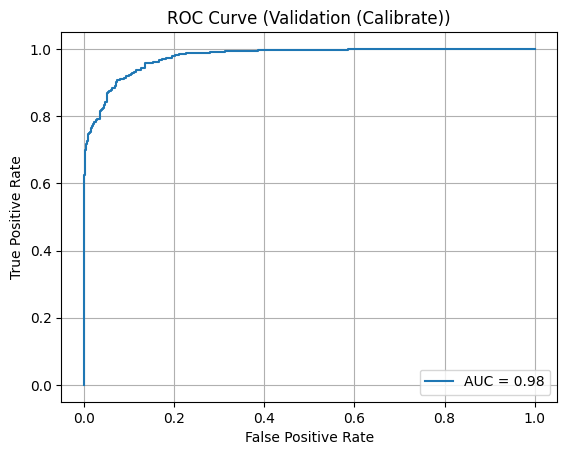

🔍 Test Set Evaluation (FPR-Calibrated)
📊 Results on Test
Threshold: 0.9122742414474487
Accuracy: 0.6954, F1 Score: 0.4896, ROC AUC: 0.7160
TPR (Recall): 0.5296, FPR: 0.2415
              precision    recall  f1-score   support

      Benign       0.81      0.76      0.78     17030
    Injected       0.46      0.53      0.49      6486

    accuracy                           0.70     23516
   macro avg       0.63      0.64      0.64     23516
weighted avg       0.71      0.70      0.70     23516



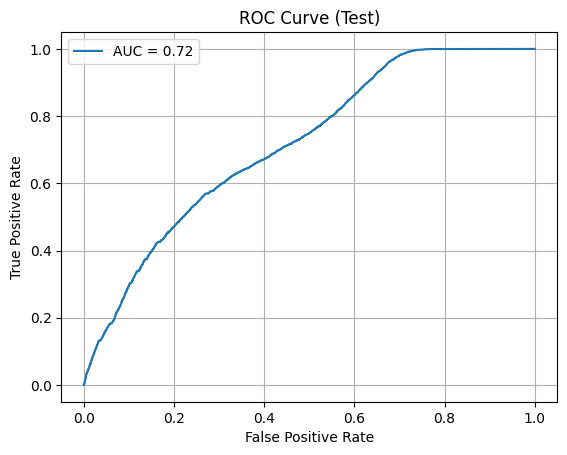

(array([0.9943772, 0.7193202, 0.9567   , ..., 0.9283963, 0.343152 ,
        0.9119484], shape=(23516,), dtype=float32),
 array([0, 0, 0, ..., 0, 0, 1], shape=(23516,)))

In [49]:
# Step 1: Calibrate threshold using validation set
val_probs, val_labels = full_evaluation(model, val_loader, name="Validation (Calibrate)")
target_fpr = 0.01
calibrated_threshold = get_threshold_at_target_fpr(val_labels, val_probs, target_fpr=target_fpr)

# Step 2: Evaluate on test set using that threshold
print("🔍 Test Set Evaluation (FPR-Calibrated)")
full_evaluation(model, test_loader, name="Test", threshold=calibrated_threshold)